<a href="https://colab.research.google.com/github/Abhayhindocha/social_network_analysis/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tweepy pymongo networkx matplotlib

In [13]:
import os
import tweepy
import pymongo
import networkx as nx
import matplotlib.pyplot as plt

In [23]:
import os
import tweepy
import pymongo
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import userdata

# 🔐 Load secrets from Colab environment using userdata.get()
consumer_key = userdata.get("TWITTER_API_KEY")
consumer_secret = userdata.get("TWITTER_API_SECERT") # Corrected secret name based on typical naming
access_token = userdata.get("BEARER_TOKEN") # Assuming you named it this in secrets
access_token_secret = userdata.get("ACCESS_TOKEN_SECRET") # Assuming you named it this in secrets

# ✅ Authenticate with Twitter (OAuth1.0a)
# Check if keys are loaded before attempting authentication
if consumer_key and consumer_secret and access_token and access_token_secret:
    try:
        auth = tweepy.OAuth1UserHandler(
            consumer_key, consumer_secret, access_token, access_token_secret
        )
        api = tweepy.API(auth, wait_on_rate_limit=True)
        print("Twitter API authentication successful!")
    except tweepy.TweepyException as e:
        print(f"Error during Twitter API authentication: {e}")
        print("Please double-check your API keys and access levels in the Twitter Developer Portal.")
else:
    print("Twitter API keys not loaded. Please ensure they are correctly stored in Colab secrets.")


Twitter API authentication successful!


In [27]:
# Get from secrets
mongo_connection_string = userdata.get('MONGO_CONNECTION_STRING')

# Connect to MongoDB
try:
    client = pymongo.MongoClient(mongo_connection_string)
    client.admin.command('ismaster')
    print("✅ MongoDB connection successful!")
except Exception as e:
    print(f"❌ MongoDB connection error: {e}")

✅ MongoDB connection successful!


In [ ]:
import tweepy
import pymongo
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import userdata

# 🔐 Load secrets
bearer_token = userdata.get("BEARER_TOKEN")
mongo_connection_string = userdata.get("MONGO_CONNECTION_STRING")

# ✅ Connect to Twitter API v2
try:
    client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)
    print("✅ Twitter API v2 authenticated successfully!")
except Exception as e:
    print("❌ Twitter v2 Authentication Error:", e)

# ✅ Connect to MongoDB
try:
    mongo = pymongo.MongoClient(mongo_connection_string)
    db = mongo["twitter_sna"]
    collection = db["tweets"]
    print("✅ Connected to MongoDB:", db.name)
except Exception as e:
    print("❌ MongoDB connection error:", e)

# ✅ Fetch tweets using Twitter API v2
def fetch_and_store_tweets_v2(query="#AI", max_results=500):
    try:
        tweets = tweepy.Paginator(
            client.search_recent_tweets,
            query=query,
            tweet_fields=["entities", "author_id"],
            max_results=50
        ).flatten(limit=max_results)

        for tweet in tweets:
            mentions = []
            if tweet.entities and 'mentions' in tweet.entities:
                mentions = [m['username'] for m in tweet.entities['mentions']]
            tweet_data = {
                "id": tweet.id,
                "text": tweet.text,
                "author_id": tweet.author_id,
                "mentions": mentions
            }
            collection.update_one({"id": tweet.id}, {"$set": tweet_data}, upsert=True)
        print(f"✅ Fetched and stored {max_results} tweets.")
    except Exception as e:
        print("❌ Error fetching tweets:", e)

# ✅ Build and visualize mention graph
def build_graph_and_visualize():
    G = nx.DiGraph()
    for tweet in collection.find():
        user = tweet.get("author_id")
        mentions = tweet.get("mentions", [])
        for mentioned in mentions:
            if G.has_edge(user, mentioned):
                G[user][mentioned]['weight'] += 1
            else:
                G.add_edge(user, mentioned, weight=1)

    # Visualization
    plt.figure(figsize=(12, 8))
    top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
    H = G.subgraph([n for n, _ in top_nodes])
    pos = nx.spring_layout(H)
    weights = [H[u][v]['weight'] for u, v in H.edges()]
    nx.draw(H, pos, with_labels=True, node_size=800, node_color='skyblue',
            width=2, edge_color=weights, edge_cmap=plt.cm.Blues)
    plt.title("Twitter Mention Graph")
    plt.show()

# 🚀 Run the workflow
fetch_and_store_tweets_v2("#AI", max_results=500)
build_graph_and_visualize()


✅ Twitter API v2 authenticated successfully!
✅ Connected to MongoDB: twitter_sna


In [57]:
import matplotlib.pyplot as plt
import networkx as nx

def build_graph_and_visualize():
    G = nx.DiGraph()

    # Build graph from MongoDB tweets
    for tweet in collection.find():
        user = str(tweet.get("author_id"))
        mentions = tweet.get("mentions", [])
        for mentioned in mentions:
            mentioned = str(mentioned)
            if G.has_edge(user, mentioned):
                G[user][mentioned]['weight'] += 1
            else:
                G.add_edge(user, mentioned, weight=1)

    print(f"Total nodes: {G.number_of_nodes()}, Total edges: {G.number_of_edges()}")

    # Get top 30 nodes by degree
    top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:30]
    top_node_ids = [node for node, _ in top_nodes]
    H = G.subgraph(top_node_ids)

    # Create layout
    pos = nx.spring_layout(H, k=0.5, seed=42)

    # Node sizes and edge weights
    node_sizes = [H.degree(n) * 300 for n in H.nodes()]
    edge_weights = [H[u][v]['weight'] for u, v in H.edges()]
    edge_colors = edge_weights

    # 🎨 Draw graph with darker edge color (magma)
    fig, ax = plt.subplots(figsize=(14, 10))
    nx.draw_networkx_nodes(H, pos, ax=ax, node_size=node_sizes, node_color='lightblue', edgecolors='black')
    edges = nx.draw_networkx_edges(
        H, pos, ax=ax,
        width=edge_weights,
        edge_color=edge_colors,
        edge_cmap=plt.cm.magma,
        edge_vmin=min(edge_weights),
        edge_vmax=max(edge_weights)
    )
    nx.draw_networkx_labels(H, pos, ax=ax, font_size=9, font_color='black')

    # ✅ Add colorbar linked to edges
    sm = plt.cm.ScalarMappable(cmap=plt.cm.magma, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Mention Frequency', fontsize=12)

    ax.set_title("Twitter Mention Graph (Top 30 Active Users)", fontsize=15)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


Total nodes: 120, Total edges: 120


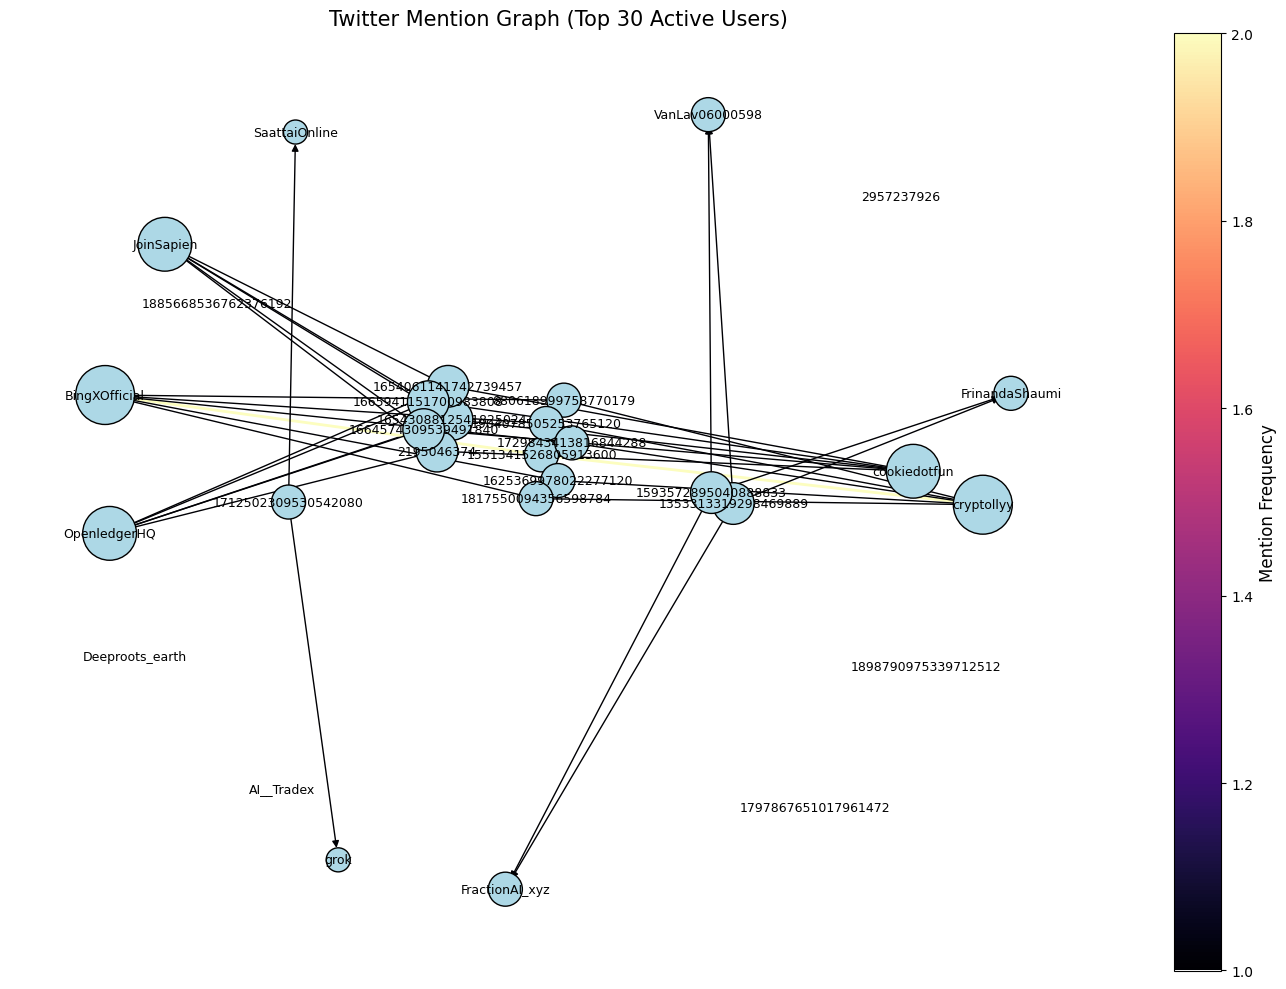

In [58]:
build_graph_and_visualize()
